In [1]:
!pip -q install imbalanced-learn xgboost


In [2]:
from google.colab import drive
import os
import pandas as pd

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/doan_demo')

df = pd.read_csv('x_ray_and_features_data.csv')
print("df shape:", df.shape)
print("columns:", df.columns[:20].tolist(), "...")


Mounted at /content/drive
df shape: (29083, 48)
columns: ['subject_id', 'diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature', 'hemoglobin', 'rbc', 'wbc', 'sputum_culture', 'smoke', 'cough', 'pneumonia', 'tuberculosis', 'bronchitis', 'arthritis', 'fracture', 'lung_cancer', 'scoliosis'] ...


In [3]:
diseases = [
    'pneumonia', 'tuberculosis', 'bronchitis', 'arthritis',
    'fracture', 'lung_cancer', 'scoliosis', 'lung_infection'
]

mimic_feats = [
    'diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature',
    'hemoglobin', 'rbc', 'wbc', 'smoke', 'cough'
]

img_feats = [str(x) for x in range(18)]

need_cols = set(diseases + mimic_feats + img_feats)
missing = [c for c in need_cols if c not in df.columns]
print("Missing cols:", missing)


Missing cols: []


In [4]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier

def compute_metrics(y_true, y_pred):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "bal_acc": balanced_accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "cm": confusion_matrix(y_true, y_pred),
    }


In [5]:
def fit_predict_logreg_img(X_train, y_train, X_test, random_state=42):
    # LogisticRegression trên img_feats
    lr = LogisticRegression(
        max_iter=2000,
        solver="liblinear",
        random_state=random_state
    )
    lr.fit(X_train, y_train)
    return lr.predict(X_test)

def fit_predict_xgb_ros(X_train, y_train, X_test, ros_ratio=1.0, random_state=42):
    """
    XGB + ROS on TRAIN only.
    ros_ratio: target n_pos_after = ros_ratio * n_neg (chỉ apply nếu class 1 là minority)
    """
    vc = y_train.value_counts()
    n_pos = int(vc.get(1, 0))
    n_neg = int(vc.get(0, 0))

    # XGB config
    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=random_state
    )

    # nếu không đủ 2 lớp hoặc class 1 không phải minority => không ROS (train XGB bình thường)
    if n_pos == 0 or n_neg == 0 or n_pos >= n_neg:
        xgb.fit(X_train, y_train)
        return xgb.predict(X_test), False

    target_n_pos = int(np.ceil(ros_ratio * n_neg))

    # nếu target <= hiện tại => không cần ROS
    if target_n_pos <= n_pos:
        xgb.fit(X_train, y_train)
        return xgb.predict(X_test), False

    pipe = Pipeline(steps=[
        ("ros", RandomOverSampler(sampling_strategy={1: target_n_pos}, random_state=random_state)),
        ("xgb", xgb)
    ])
    pipe.fit(X_train, y_train)
    return pipe.predict(X_test), True


In [6]:
def eval_aug_triplet_one_disease(
    df: pd.DataFrame,
    disease: str,
    img_feats: list,
    mimic_feats: list,
    test_size: float = 0.2,
    random_state: int = 42,
    ros_ratio: float = 1.0,   # 1.0 = cân bằng 1:1 (pos = neg) nếu pos là minority
):
    # data cho img_only và all_feats
    feat_img = list(img_feats)
    feat_all = list(img_feats) + list(mimic_feats)

    # dropna theo ALL features để 3 model dùng cùng cohort (fair)
    data = df[feat_all + [disease]].dropna().copy()
    X_img = data[feat_img]
    X_all = data[feat_all]
    y = data[disease].astype(int)

    if y.nunique() < 2:
        return None

    Ximg_tr, Ximg_te, y_tr, y_te = train_test_split(
        X_img, y, test_size=test_size, random_state=random_state, stratify=y
    )

    Xall_tr = X_all.loc[Ximg_tr.index]
    Xall_te = X_all.loc[Ximg_te.index]

    # 1) LogReg(img) baseline
    pred_lr = fit_predict_logreg_img(Ximg_tr, y_tr, Ximg_te, random_state=random_state)
    m_lr = compute_metrics(y_te, pred_lr)

    # 2) Model+Aug(img) = XGB + ROS (img_only)
    pred_aug_img, ros_applied_img = fit_predict_xgb_ros(
        Ximg_tr, y_tr, Ximg_te, ros_ratio=ros_ratio, random_state=random_state
    )
    m_aug_img = compute_metrics(y_te, pred_aug_img)

    # 3) Model+Aug(all) = XGB + ROS (all_feats)
    pred_aug_all, ros_applied_all = fit_predict_xgb_ros(
        Xall_tr, y_tr, Xall_te, ros_ratio=ros_ratio, random_state=random_state
    )
    m_aug_all = compute_metrics(y_te, pred_aug_all)

    return {
        "disease": disease,
        "n": int(len(y)),
        "pos": int((y == 1).sum()),
        "pos_rate": float((y == 1).mean()),
        "lr_img": m_lr,
        "aug_img": m_aug_img,
        "aug_all": m_aug_all,
        "ros_applied_img": ros_applied_img,
        "ros_applied_all": ros_applied_all
    }


In [7]:
def run_aug_triplet_experiment(
    df: pd.DataFrame,
    diseases: list,
    img_feats: list,
    mimic_feats: list,
    ros_ratio: float = 1.0,
    n_repeats: int = 5,
    test_size: float = 0.2,
    seed0: int = 42
):
    rows = []

    for d in diseases:
        lr_list, aug_img_list, aug_all_list = [], [], []
        res0 = None
        applied_img = 0
        applied_all = 0
        valid_runs = 0

        for r in range(n_repeats):
            rs = seed0 + r
            res = eval_aug_triplet_one_disease(
                df=df, disease=d,
                img_feats=img_feats, mimic_feats=mimic_feats,
                test_size=test_size, random_state=rs,
                ros_ratio=ros_ratio
            )
            if res is None:
                continue

            if res0 is None:
                res0 = res

            lr_list.append(res["lr_img"])
            aug_img_list.append(res["aug_img"])
            aug_all_list.append(res["aug_all"])

            applied_img += int(res["ros_applied_img"])
            applied_all += int(res["ros_applied_all"])
            valid_runs += 1

        if res0 is None or valid_runs == 0:
            continue

        def agg(lst, key):
            vals = np.array([m[key] for m in lst], dtype=float)
            return float(vals.mean()), float(vals.std(ddof=0))

        out = {
            "disease": d,
            "n": res0["n"],
            "pos": res0["pos"],
            "pos_rate": res0["pos_rate"],
            "valid_runs": valid_runs,
            "ros_applied_img_rate": applied_img / valid_runs,
            "ros_applied_all_rate": applied_all / valid_runs,
        }

        for metric in ["acc", "precision", "recall", "f1"]:
            out[f"lr_{metric}_mean"], out[f"lr_{metric}_std"] = agg(lr_list, metric)
            out[f"aug_img_{metric}_mean"], out[f"aug_img_{metric}_std"] = agg(aug_img_list, metric)
            out[f"aug_all_{metric}_mean"], out[f"aug_all_{metric}_std"] = agg(aug_all_list, metric)

        rows.append(out)

    return pd.DataFrame(rows)

results_aug = run_aug_triplet_experiment(
    df=df,
    diseases=diseases,
    img_feats=img_feats,
    mimic_feats=mimic_feats,
    ros_ratio=1.0,    # Muốn “Aug” mạnh => 1.0
    n_repeats=5,
    test_size=0.2,
    seed0=42
)

results_aug.sort_values("pos_rate")


,disease,n,pos,pos_rate,valid_runs,ros_applied_img_rate,ros_applied_all_rate,lr_acc_mean,lr_acc_std,aug_img_acc_mean,...,aug_img_recall_mean,aug_img_recall_std,aug_all_recall_mean,aug_all_recall_std,lr_f1_mean,lr_f1_std,aug_img_f1_mean,aug_img_f1_std,aug_all_f1_mean,aug_all_f1_std
6,scoliosis,1697,9,0.005303,5,1.0,1.0,0.994118,0.000000e+00,0.992941,...,0.000000,0.000000,0.400000,0.374166,0.000000,0.000000,0.000000,0.000000,0.466667,0.400000
1,tuberculosis,1697,47,0.027696,5,1.0,1.0,0.973529,1.110223e-16,0.967647,...,0.044444,0.054433,0.577778,0.215452,0.000000,0.000000,0.080000,0.097980,0.708235,0.177667
3,arthritis,1697,53,0.031232,5,1.0,1.0,0.967647,1.110223e-16,0.964118,...,0.000000,0.000000,0.145455,0.072727,0.000000,0.000000,0.000000,0.000000,0.232381,0.107809
7,lung_infection,1697,80,0.047142,5,1.0,1.0,0.952941,0.000000e+00,0.938235,...,0.025000,0.030619,0.137500,0.082916,0.000000,0.000000,0.035573,0.043586,0.208339,0.121834
2,bronchitis,1697,122,0.071892,5,1.0,1.0,0.929412,0.000000e+00,0.897647,...,0.133333,0.061237,0.358333,0.100692,0.000000,0.000000,0.153557,0.060635,0.429194,0.105085
4,fracture,1697,229,0.134944,5,1.0,1.0,0.864706,1.110223e-16,0.810588,...,0.091304,0.021300,0.265217,0.037401,0.000000,0.000000,0.115300,0.021981,0.317301,0.016377
5,lung_cancer,1697,382,0.225103,5,1.0,1.0,0.772941,1.176471e-03,0.685882,...,0.168831,0.023232,0.368831,0.037280,0.000000,0.000000,0.195530,0.024371,0.422189,0.037654
0,pneumonia,1697,1079,0.635828,5,0.0,0.0,0.655294,1.106758e-02,0.645294,...,0.836111,0.034595,0.883333,0.027059,0.777185,0.006902,0.749421,0.019747,0.845979,0.009037


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

METRICS = ["Accuracy", "Precision", "Recall", "F1"]

def pp_change(new, old):
    return (np.asarray(new, dtype=float) - np.asarray(old, dtype=float)) * 100.0

def plot_heatmap_pp(table_pp: pd.DataFrame, title: str):

    data = (table_pp / 100.0).clip(-1, 1)
    annot = table_pp.map(lambda x: "" if pd.isna(x) else f"{x:.2f}%")

    plt.figure(figsize=(10, max(6, 0.38 * len(table_pp))))
    ax = sns.heatmap(
        data, annot=annot, fmt="",
        cmap="coolwarm", center=0, vmin=-1, vmax=1,
        linewidths=0.5, linecolor="white"
    )
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Model-Disease")
    plt.tight_layout()
    plt.show()

order = pd.CategoricalDtype(categories=diseases, ordered=True)
tmp = results_aug.copy()
tmp["disease"] = tmp["disease"].astype(order)
tmp = tmp.sort_values("disease")


rows_heatmap = tmp["disease"].astype(str).tolist()



In [9]:
# =========================
# Imbalance ratio = #negative / #positive
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

feat_img = list(img_feats)
feat_all = list(img_feats) + list(mimic_feats)

# dropna theo ALL features để cohort
df_use = df[feat_all + diseases].dropna().copy()

def counts_train_before_after_ros(df_in: pd.DataFrame, disease: str, test_size=0.2, random_state=42, ros_ratio=1.0):
    """
    Đếm số mẫu lớp 0/1 trong TRAIN trước ROS và sau ROS.
    ROS chỉ áp dụng nếu class 1 là minority và target_n_pos > n_pos.
    """
    X = df_in[feat_all]   # dùng cùng cohort;
    y = df_in[disease].astype(int)

    if y.nunique() < 2:
        return None

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    neg_before = int((y_tr == 0).sum())
    pos_before = int((y_tr == 1).sum())

    # mặc định after = before (nếu không ROS)
    neg_after, pos_after = neg_before, pos_before
    ros_applied = False

    # ROS chỉ khi pos là minority
    if pos_before > 0 and neg_before > 0 and pos_before < neg_before:
        target_n_pos = int(np.ceil(ros_ratio * neg_before))
        if target_n_pos > pos_before:
            ros = RandomOverSampler(sampling_strategy={1: target_n_pos}, random_state=random_state)
            X_ros, y_ros = ros.fit_resample(X_tr, y_tr)
            neg_after = int((y_ros == 0).sum())
            pos_after = int((y_ros == 1).sum())
            ros_applied = True

    ratio_before = (neg_before / pos_before) if pos_before > 0 else np.inf
    ratio_after  = (neg_after  / pos_after)  if pos_after  > 0 else np.inf

    return {
        "disease": disease,
        "neg_before": neg_before,
        "pos_before": pos_before,
        "neg_after": neg_after,
        "pos_after": pos_after,
        "ratio_before": ratio_before,
        "ratio_after": ratio_after,
        "ros_applied": ros_applied
    }

# --- chạy cho 8 bệnh ---
seed = 42
rows_ros = []
for dis in diseases:
    out = counts_train_before_after_ros(df_use, dis, test_size=0.2, random_state=seed, ros_ratio=1.0)
    if out is not None:
        rows_ros.append(out)

ros_table = pd.DataFrame(rows_ros).set_index("disease")

# Optional
display(
    ros_table[["neg_before","pos_before","neg_after","pos_after","ratio_before","ratio_after","ros_applied"]]
    .sort_index()
)


,neg_before,pos_before,neg_after,pos_after,ratio_before,ratio_after,ros_applied
disease,,,,,,,
arthritis,1315,42,1315,1315,31.309524,1.000000,True
bronchitis,1259,98,1259,1259,12.846939,1.000000,True
fracture,1174,183,1174,1174,6.415301,1.000000,True
lung_cancer,1052,305,1052,1052,3.449180,1.000000,True
lung_infection,1293,64,1293,1293,20.203125,1.000000,True
pneumonia,494,863,494,863,0.572422,0.572422,False
scoliosis,1350,7,1350,1350,192.857143,1.000000,True
tuberculosis,1319,38,1319,1319,34.710526,1.000000,True


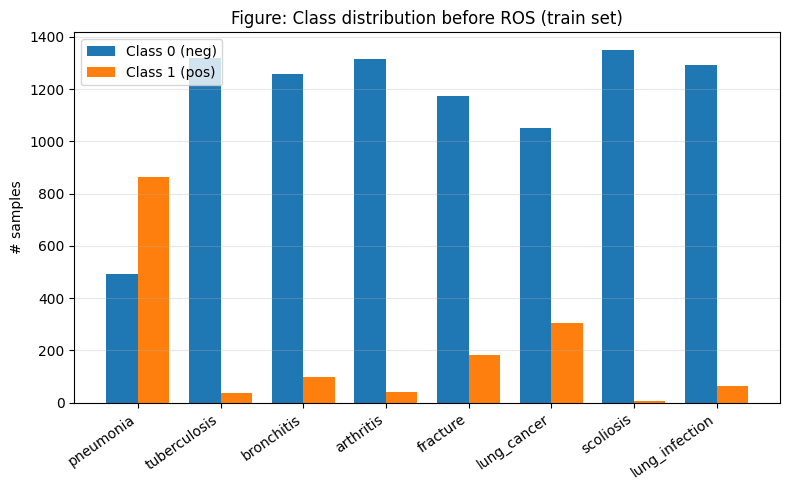

In [10]:
x = np.arange(len(ros_table.index))
w = 0.38

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x - w/2, ros_table["neg_before"].values, width=w, label="Class 0 (neg)")
ax.bar(x + w/2, ros_table["pos_before"].values, width=w, label="Class 1 (pos)")

ax.set_title("Figure: Class distribution before ROS (train set)")
ax.set_xticks(x)
ax.set_xticklabels(ros_table.index.tolist(), rotation=35, ha="right")
ax.set_ylabel("# samples")
ax.grid(axis="y", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


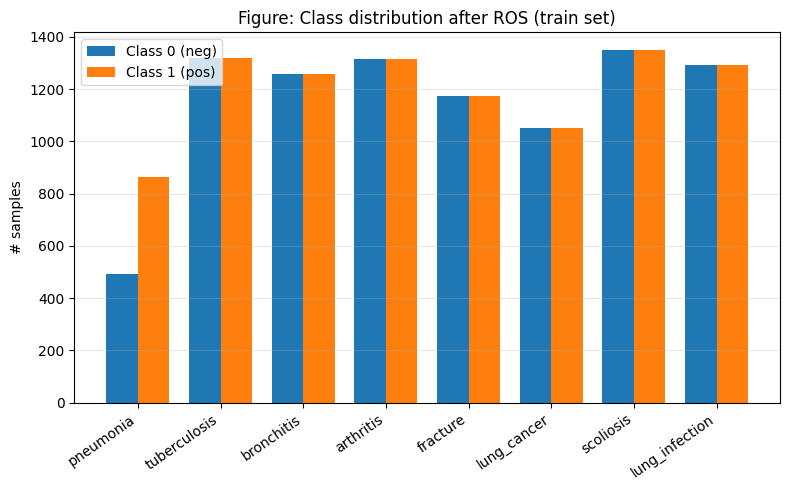

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x - w/2, ros_table["neg_after"].values, width=w, label="Class 0 (neg)")
ax.bar(x + w/2, ros_table["pos_after"].values, width=w, label="Class 1 (pos)")

ax.set_title("Figure: Class distribution after ROS (train set)")
ax.set_xticks(x)
ax.set_xticklabels(ros_table.index.tolist(), rotation=35, ha="right")
ax.set_ylabel("# samples")
ax.grid(axis="y", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Optional save
# fig.savefig("Figure_7B_after_ROS.png", dpi=300, bbox_inches="tight"

In [12]:

def plot_heatmap_mean_std(mean_df, std_df, title,
                          annot_font=12, tick_font=12, title_font=14, cbar_font=12):
    """
    mean_df/std_df đang là 'percentage points' rồi (vd 15.06 nghĩa là 15.06%)
    -> Annotation hiển thị: 15.06 ± 3.29 (không có dấu %)
    """
    data = (mean_df / 100.0).clip(-1, 1)

    annot = mean_df.copy().astype(str)
    for i in mean_df.index:
        for j in mean_df.columns:
            m = mean_df.loc[i, j]
            s = std_df.loc[i, j]
            if pd.isna(m):
                annot.loc[i, j] = ""
            elif pd.isna(s):
                annot.loc[i, j] = f"{m:.2f}"
            else:
                annot.loc[i, j] = f"{m:.2f} ± {s:.2f}"

    plt.figure(figsize=(11, max(6, 0.45 * len(mean_df))))
    ax = sns.heatmap(
        data,
        annot=annot, fmt="",
        cmap="coolwarm", center=0, vmin=-1, vmax=1,
        linewidths=0.5, linecolor="white",
        cbar_kws={"label": "Mean gain"},
        annot_kws={"fontsize": annot_font}
    )

    ax.set_title(title, fontsize=title_font)
    ax.set_xlabel("")
    ax.set_ylabel("Disease", fontsize=tick_font)
    ax.tick_params(axis='x', labelsize=tick_font)
    ax.tick_params(axis='y', labelsize=tick_font)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=cbar_font)
    cbar.set_label("Mean gain", fontsize=cbar_font)

    plt.tight_layout()
    plt.show()


def draw_heatmap_mean_std(ax, mean_df, std_df, title, show_cbar=False,
                          annot_font=12, tick_font=12, title_font=14, cbar_font=12):
    data = (mean_df / 100.0).clip(-1, 1)

    annot = mean_df.copy().astype(str)
    for i in mean_df.index:
        for j in mean_df.columns:
            m = mean_df.loc[i, j]
            s = std_df.loc[i, j]
            if pd.isna(m):
                annot.loc[i, j] = ""
            elif pd.isna(s):
                annot.loc[i, j] = f"{m:.2f}"
            else:
                annot.loc[i, j] = f"{m:.2f} ± {s:.2f}"

    hm = sns.heatmap(
        data, ax=ax,
        annot=annot, fmt="",
        cmap="coolwarm", center=0, vmin=-1, vmax=1,
        linewidths=0.5, linecolor="white",
        cbar=show_cbar,
        cbar_kws={"label": "Mean gain"} if show_cbar else None,
        annot_kws={"fontsize": annot_font}
    )

    ax.set_title(title, fontsize=title_font)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelsize=tick_font)
    ax.tick_params(axis='y', labelsize=tick_font)

    if show_cbar:
        cbar = hm.collections[0].colorbar
        cbar.ax.tick_params(labelsize=cbar_font)
        cbar.set_label("Mean gain", fontsize=cbar_font)


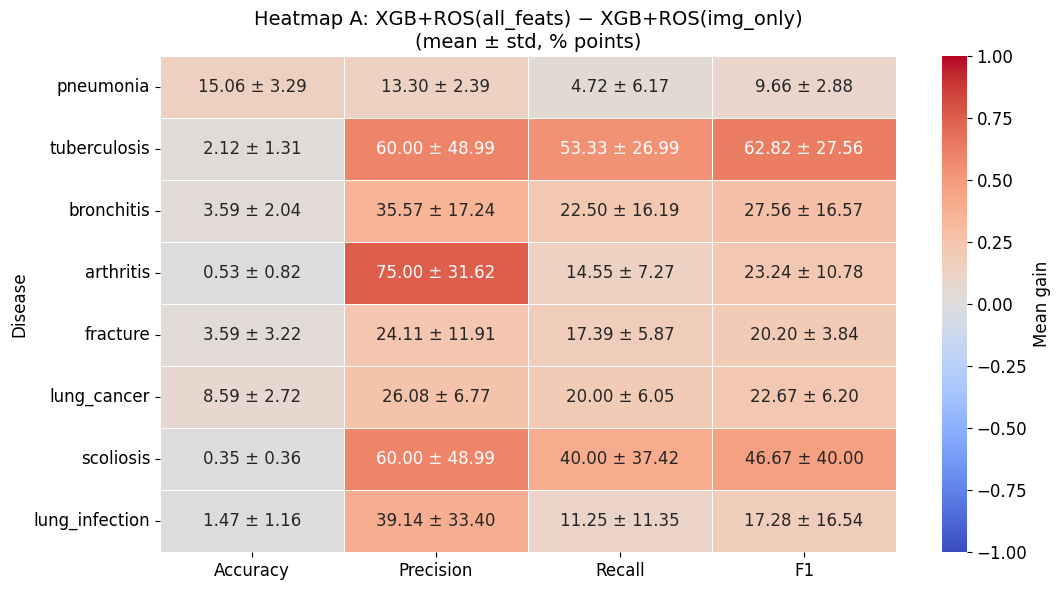

In [13]:
# # --- Aug-Heatmap A: Model+Aug(all) - Model+Aug(img) ---
# A: XGB+ROS(all_feats) − XGB+ROS(img_only)

A_mean = pd.DataFrame(index=rows_heatmap, columns=METRICS, dtype=float)
A_mean["Accuracy"]  = pp_change(tmp["aug_all_acc_mean"],       tmp["aug_img_acc_mean"])
A_mean["Precision"] = pp_change(tmp["aug_all_precision_mean"], tmp["aug_img_precision_mean"])
A_mean["Recall"]    = pp_change(tmp["aug_all_recall_mean"],    tmp["aug_img_recall_mean"])
A_mean["F1"]        = pp_change(tmp["aug_all_f1_mean"],        tmp["aug_img_f1_mean"])

A_std = pd.DataFrame(index=rows_heatmap, columns=METRICS, dtype=float)
A_std["Accuracy"]  = ((tmp["aug_all_acc_std"]       + tmp["aug_img_acc_std"]) * 100).values
A_std["Precision"] = ((tmp["aug_all_precision_std"] + tmp["aug_img_precision_std"]) * 100).values
A_std["Recall"]    = ((tmp["aug_all_recall_std"]    + tmp["aug_img_recall_std"]) * 100).values
A_std["F1"]        = ((tmp["aug_all_f1_std"]        + tmp["aug_img_f1_std"]) * 100).values


plot_heatmap_mean_std(
    A_mean, A_std,
    "Heatmap A: XGB+ROS(all_feats) − XGB+ROS(img_only)\n(mean ± std, % points)",
    annot_font=12, tick_font=12, title_font=14, cbar_font=12)


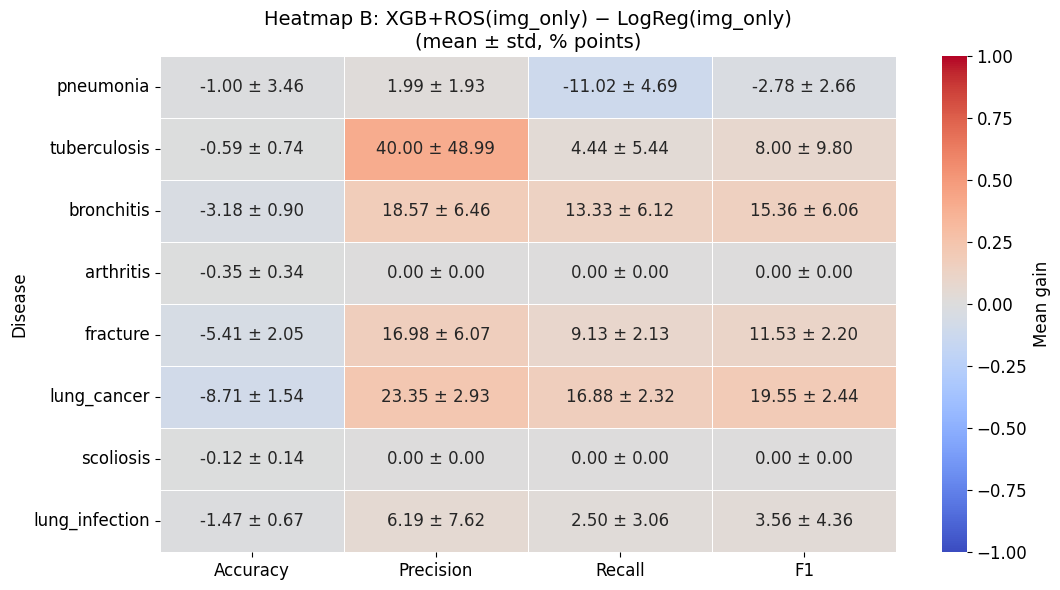

In [14]:
# # --- Aug-Heatmap B: Model+Aug(img) - LogReg(img) ---
# B: XGB+ROS(img_only) − LogReg(img_only)

B_mean = pd.DataFrame(index=rows_heatmap, columns=METRICS, dtype=float)
B_mean["Accuracy"]  = pp_change(tmp["aug_img_acc_mean"],       tmp["lr_acc_mean"])
B_mean["Precision"] = pp_change(tmp["aug_img_precision_mean"], tmp["lr_precision_mean"])
B_mean["Recall"]    = pp_change(tmp["aug_img_recall_mean"],    tmp["lr_recall_mean"])
B_mean["F1"]        = pp_change(tmp["aug_img_f1_mean"],        tmp["lr_f1_mean"])

B_std = pd.DataFrame(index=rows_heatmap, columns=METRICS, dtype=float)
B_std["Accuracy"]  = ((tmp["aug_img_acc_std"]       + tmp["lr_acc_std"]) * 100).values
B_std["Precision"] = ((tmp["aug_img_precision_std"] + tmp["lr_precision_std"]) * 100).values
B_std["Recall"]    = ((tmp["aug_img_recall_std"]    + tmp["lr_recall_std"]) * 100).values
B_std["F1"]        = ((tmp["aug_img_f1_std"]        + tmp["lr_f1_std"]) * 100).values

plot_heatmap_mean_std(
    B_mean, B_std,
    "Heatmap B: XGB+ROS(img_only) − LogReg(img_only)\n(mean ± std, % points)",
    annot_font=12, tick_font=12, title_font=14, cbar_font=12)



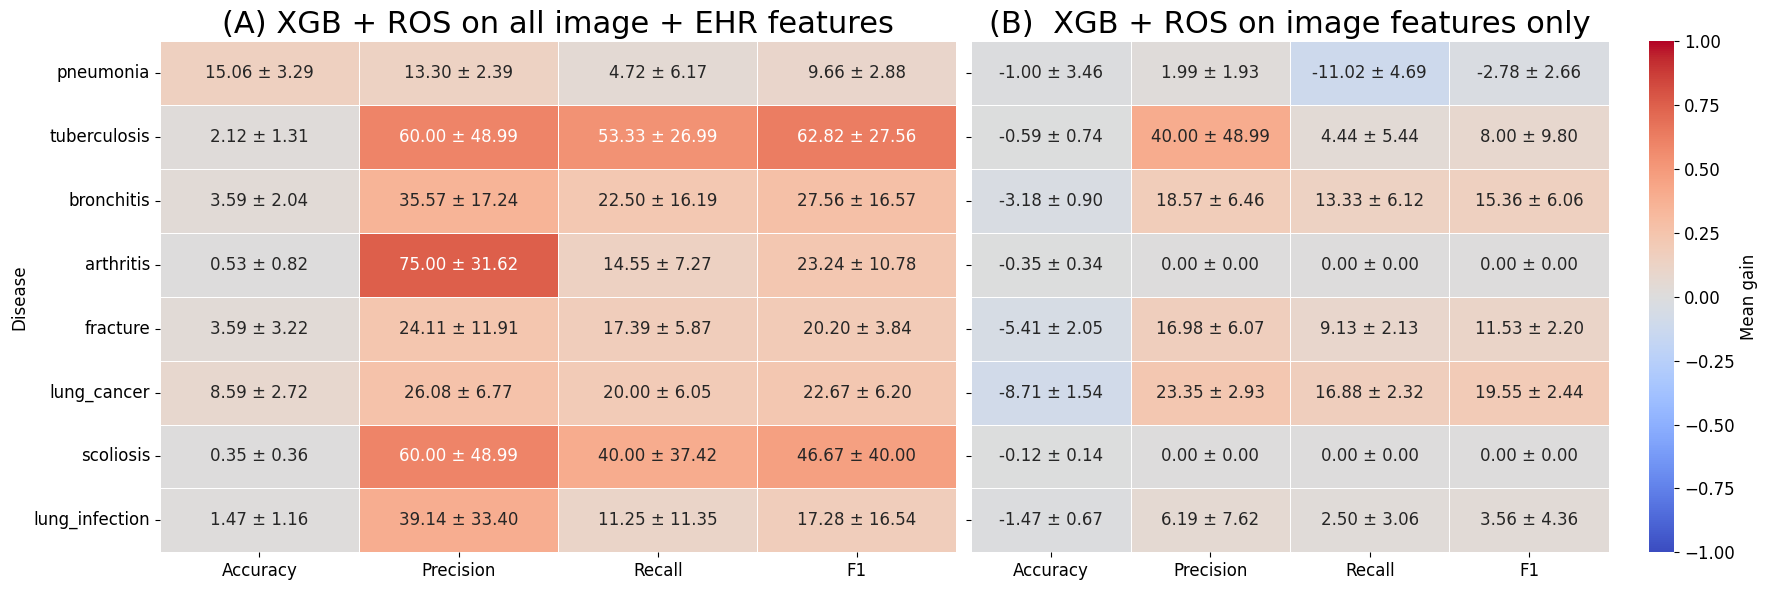

In [15]:
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(18, max(6, 0.45 * len(rows_heatmap))),
    sharey=True
)

draw_heatmap_mean_std(axes[0], A_mean, A_std, "(A) XGB + ROS on all image + EHR features", show_cbar=False,
                      annot_font=12, tick_font=12, title_font=22, cbar_font=12)

draw_heatmap_mean_std(axes[1], B_mean, B_std, "(B)  XGB + ROS on image features only", show_cbar=True,
                      annot_font=12, tick_font=12, title_font=22, cbar_font=12)

axes[0].set_ylabel("Disease", fontsize=12)
plt.tight_layout()
plt.show()


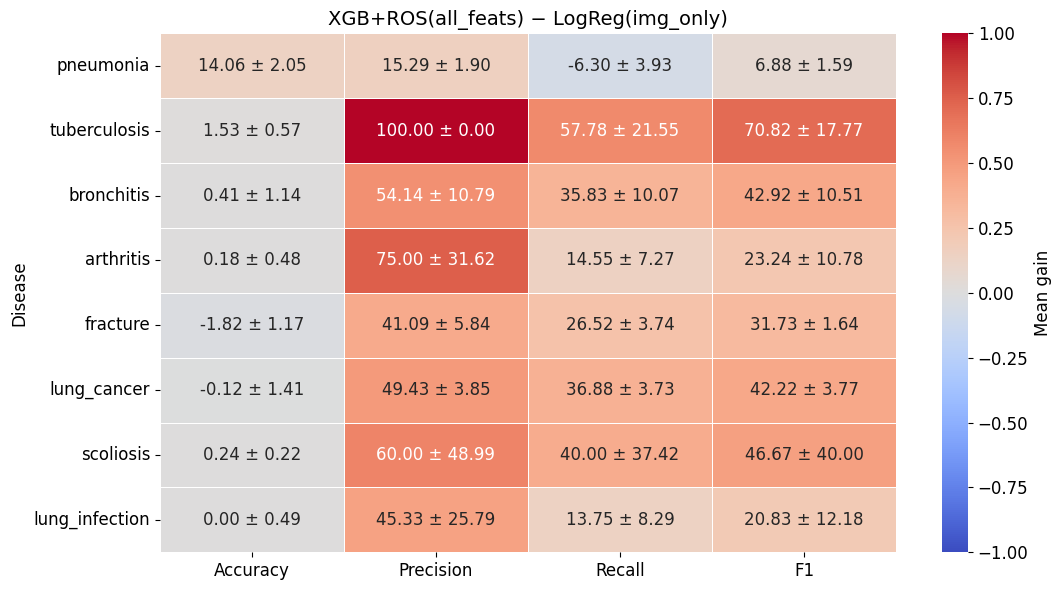

In [16]:
# # --- Aug-Heatmap C: Model+Aug(all) - LogReg(img) ---
# C: XGB+ROS(all_feats) − LogReg(img_only)

C_mean = pd.DataFrame(index=rows_heatmap, columns=METRICS, dtype=float)
C_mean["Accuracy"]  = pp_change(tmp["aug_all_acc_mean"],       tmp["lr_acc_mean"])
C_mean["Precision"] = pp_change(tmp["aug_all_precision_mean"], tmp["lr_precision_mean"])
C_mean["Recall"]    = pp_change(tmp["aug_all_recall_mean"],    tmp["lr_recall_mean"])
C_mean["F1"]        = pp_change(tmp["aug_all_f1_mean"],        tmp["lr_f1_mean"])

C_std = pd.DataFrame(index=rows_heatmap, columns=METRICS, dtype=float)
C_std["Accuracy"]  = ((tmp["aug_all_acc_std"]       + tmp["lr_acc_std"]) * 100).values
C_std["Precision"] = ((tmp["aug_all_precision_std"] + tmp["lr_precision_std"]) * 100).values
C_std["Recall"]    = ((tmp["aug_all_recall_std"]    + tmp["lr_recall_std"]) * 100).values
C_std["F1"]        = ((tmp["aug_all_f1_std"]        + tmp["lr_f1_std"]) * 100).values

plot_heatmap_mean_std(
    C_mean, C_std,
    "XGB+ROS(all_feats) − LogReg(img_only)"
)
